# Dependencies

In [1]:
import argparse

import os

import time
import torch

import matplotlib.pyplot as plt
import numpy as np

from model.dataloader import HELMETDataLoader
from model.dataloader import class_dict
from model.models import Darknet, load_weights, load_darknet_weights
from utils.utils import *

from IPython.display import clear_output

# Load in model

In [2]:
cfg_path = './cfg/yolov3.cfg'
weights_path = './weights/darknet53.conv.74'

In [3]:
### 

# Load in convolutional darknet.
# TODO: Set a default img_size for convenience.
def get_darknet(img_size, cfg=cfg_path):
    return Darknet(cfg, img_size)

img_size = 832

model = get_darknet(img_size=img_size)

# Load in weights
load_darknet_weights(model, weights_path)

# Dataloader

In [4]:
batch_size = 3

dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", shuffle=True, batch_size=batch_size)

# Dataloader unit test

In [5]:
batch = next(iter(dataloader))

imgs, targets, annotations = batch

print('Image shape:', imgs[0].shape)

out = model(imgs[0].reshape(1, 3, 832, 832))

print('Output shape:', out.shape)
print('Targets shape:', targets[0].size())

Image shape: torch.Size([3, 832, 832])
Output shape: torch.Size([1, 42588, 85])
Targets shape: torch.Size([6, 5])


# Detection "unit test"

In [6]:
# cuda = torch.cuda.is_available()
device = 'cpu' # device = torch.device('cuda:0' if cuda else 'cpu')

In [7]:
opt = {'conf_thres': .5, 
       'nms_thres': .45
      }

In [8]:
# os.system('rm -rf ' + opt.output_folder)
# os.makedirs(opt.output_folder, exist_ok=True)

model.to(device).eval()

# Set Dataloader
# classes = load_classes(opt.class_path)  # Extracts class labels from file
# dataloader = load_images(opt.image_folder, batch_size=opt.batch_size, img_size=opt.img_size)

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index
# for batch_i, (img_paths, img) in enumerate(dataloader):
#     print(batch_i, img.shape, end=' ')

batch = next(iter(dataloader))

batch_imgs, batch_targets, batch_annotations = batch

# Get detections
with torch.no_grad():
    # chip = torch.from_numpy(img).unsqueeze(0).to(device)
    pred = model(batch_imgs[0].reshape(1, 3, 832, 832)) # pred = model(chip)
    pred = pred[pred[:, :, 4] > opt['conf_thres']]

    if len(pred) > 0:
        detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
        img_detections.extend(detections)
        # imgs.extend(img_paths)

In [9]:
img_detections

[None]

(-0.5, 831.5, 831.5, -0.5)

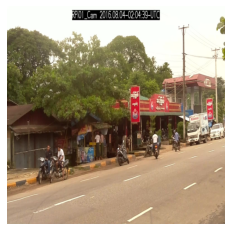

In [10]:
plt.imshow(np.array(batch_imgs[0]).transpose([1, 2, 0]))
plt.axis('off')

In [11]:
# Bugfix :D
# model.to(device).train()
# train_batch = torch.rand((3, 3, 832, 832))
# targets = [ torch.tensor([[1, .5, .5, .2, .2], [1, .4, .4, .2, .2]]) ,  torch.tensor([[1, .5, .5, .2, .2]]) , torch.tensor([]) ]
# model(train_batch, targets, requestPrecision=True)

# Training loop

In [12]:
CUTOFF = 155
# Transfer learning (train only YOLO layers)
for i, (name, p) in enumerate(model.named_parameters()):
    # print(i, p.shape[0], name)
    # if p.shape[0] != 650:  # not YOLO layer
    #    p.requires_grad = False
    if i > CUTOFF:
        p.requires_grad = False

In [13]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
# optimizer = torch.optim.SGD(
#     filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3,
#     momentum=.9, weight_decay=5e-4, nesterov=True
# )

Get device.

In [14]:
cuda_enable = False
cuda_available = torch.cuda.is_available()
if cuda_enable and cuda_available:
    device = torch.device('cuda:0')
else:
    device = 'cpu'

Train loop.

Train Time 0m 24s


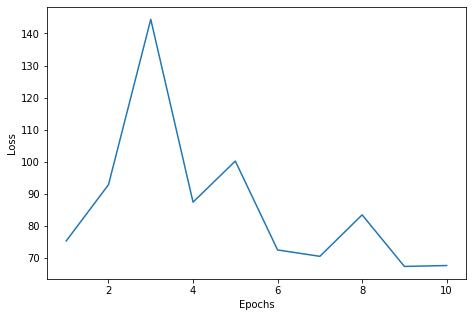

In [15]:
N_EPOCHS = 10
PLOT_EVERY = 1

model.to(device)

plot_dict = {'train_loss': [], 'train_acc': [], 'Epoch': []}

# imgs, targets, annotations = next(iter(dataloader))
# targets = list(map(lambda x: x.type(torch.FloatTensor), targets)) # To correct type.

for epoch in range(1, N_EPOCHS + 1):
    since = time.time()
    
    imgs, targets, annotations = next(iter(dataloader))
    targets = list(map(lambda x: x.type(torch.FloatTensor), targets)) # To correct type.
    
    # Train
    model.train()
    optimizer.zero_grad() # Zero gradients
    loss = model(imgs.to(device), targets, requestPrecision=True)
    loss.backward()
    optimizer.step()
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    if not (epoch - 1) % PLOT_EVERY:
        plot_dict['Epoch'].append(epoch)
        plot_dict['train_loss'].append(loss.detach().numpy())
        # plot_dict['train_acc'].append(1-trn_err)
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
        ax.plot(plot_dict['Epoch'], plot_dict['train_loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        # axs[1].plot(plot_dict['Epoch'], plot_dict['train_acc'])
        # axs[1].set_xlabel('Epochs')
        # axs[1].set_ylabel('Accuracy')
        plt.show()
    clear_output(wait=True)


In [16]:
model.to(device).eval()
img_detections = []

# Get detections
with torch.no_grad():
    pred = model(imgs[0].reshape(1, 3, 832, 832)) # pred = model(chip)
    pred = pred[pred[:, :, 4] > opt['conf_thres']]

    if len(pred) > 0:
        detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
        img_detections.extend(detections)

C:\Programming\Python\02456-deep-learning\Project\02456-yolo\utils\utils.py:336: RuntimeWarning: overflow encountered in multiply
  a = w * h  # area
C:\Programming\Python\02456-deep-learning\Project\02456-yolo\utils\utils.py:337: RuntimeWarning: overflow encountered in true_divide
  ar = w / (h + 1e-16)  # aspect ratio


In [17]:
img = imgs[0]
detections = img_detections[0]

# The amount of padding that was added
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
# Image height and width after padding is removed
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

# Draw bounding boxes and labels of detections
if detections is not None:
    unique_classes = detections[:, -1].cpu().unique()

    for i in unique_classes:
        n = (detections[:, -1].cpu() == i).sum()
        # print('%g %ss' % (n, classes[int(i)]))

    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        # Rescale coordinates to original dimensions
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = (((y1 - pad_y // 2) / unpad_h) * img.shape[0]).round().item()
        x1 = (((x1 - pad_x // 2) / unpad_w) * img.shape[1]).round().item()
        x2 = (x1 + box_w).round().item()
        y2 = (y1 + box_h).round().item()
        x1, y1, x2, y2 = max(x1, 0), max(y1, 0), max(x2, 0), max(y2, 0)
        # print(x1, y1, x2, y2)
        # print(int(cls_pred))
        print(list(class_dict.keys())[int(cls_pred)])
# print(annotations[0])
# detections

DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelmetP0NoHelmet
DNoHelme

IndexError: list index out of range

(-0.5, 831.5, 831.5, -0.5)

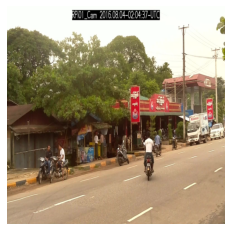

In [18]:
plt.imshow(np.array(img).transpose([1, 2, 0]))
plt.axis('off')